# Basic Settings

In [0]:
import pandas as pd
import numpy as np
import gensim

In [2]:
import os
os.getcwd()

'/content'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
from collections import defaultdict
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import f1_score

from tqdm import tqdm

# model
import lightgbm as lgb

SEED=42
LABEL=None

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
# train
# path = 'drive/My Drive/bigcontest2019/data/'
path = 'drive/My Drive/bigcontest2019/'
train_activity = pd.read_csv(path + 'data/train/train_activity.csv').drop(columns='fishing')
train_payment = pd.read_csv(path + 'data/train/train_payment.csv')
train_trade = pd.read_csv(path + 'data/train/train_trade.csv')
train_pledge = pd.read_csv(path + 'data/train/train_pledge.csv').drop(columns=['combat_play_time', 'non_combat_play_time'])
train_combat = pd.read_csv(path + 'data/train/train_combat.csv')

test1_activity = pd.read_csv(path+'data/test/test1_activity.csv').drop(columns='fishing')
test1_combat = pd.read_csv(path+'data/test/test1_combat.csv')
test1_payment = pd.read_csv(path+'data/test/test1_payment.csv')
test1_pledge = pd.read_csv(path+'data/test/test1_pledge.csv').drop(columns=['combat_play_time', 'non_combat_play_time'])
test1_trade = pd.read_csv(path+'data/test/test1_trade.csv')

test2_activity = pd.read_csv(path + 'data/test/test2_activity.csv').drop(columns='fishing')
test2_combat = pd.read_csv(path + 'data/test/test2_combat.csv')
test2_payment = pd.read_csv(path + 'data/test/test2_payment.csv')
test2_pledge = pd.read_csv(path + 'data/test/test2_pledge.csv').drop(columns=['combat_play_time', 'non_combat_play_time'])
test2_trade = pd.read_csv(path + 'data/test/test2_trade.csv')

train_label = pd.read_csv(path+'data/train/train_label.csv')

In [0]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


In [0]:
activity_all_df = pd.concat([pd.concat([train_activity,test1_activity]),test2_activity])
combat_all_df = pd.concat([pd.concat([train_combat,test1_combat]),test2_combat])
trade_all_df = pd.concat([pd.concat([train_trade,test1_trade]),test2_trade])
pledge_all_df = pd.concat([pd.concat([train_pledge,test1_pledge]),test2_pledge])
payment_all_df = pd.concat([pd.concat([train_payment,test1_payment]),test2_payment])

In [6]:
# activity_all_df = reduce_mem_usage(activity_all_df)
# combat_all_df = reduce_mem_usage(combat_all_df)
# trade_all_df = reduce_mem_usage(trade_all_df)
# pledge_all_df = reduce_mem_usage(pledge_all_df)
# payment_all_df = reduce_mem_usage(payment_all_df)

Mem. usage decreased to 140.70 Mb (64.7% reduction)
Mem. usage decreased to 116.30 Mb (63.4% reduction)
Mem. usage decreased to 169.18 Mb (43.8% reduction)
Mem. usage decreased to 86.21 Mb (59.8% reduction)
Mem. usage decreased to  1.67 Mb (53.1% reduction)


# User 2 Vector

## Class

In [0]:
class User2Vec(object):
    def __init__(self, data):
        self.data = data
        self.groupby_dict = defaultdict()
        self.groupby_dict2 = defaultdict()
        self.group_df = pd.DataFrame()
        self.similiraty_dict = defaultdict(list)
        self.user2vec_df = pd.DataFrame()

    def activity_dict(self):        
        temp_df = pd.get_dummies(self.data)

        for feature in temp_df.columns:
            if feature == 'acc_id' or feature == 'day':
                pass
            elif feature == 'char_id':
                self.groupby_dict[feature] = 'nunique'
            else:
                self.groupby_dict[feature] = 'sum'
        else:
            self.group_df = temp_df.groupby(['acc_id','day']).agg(self.groupby_dict).reset_index()
    
        return self.group_df, self.groupby_dict

    def payment_dict(self):
        for feature in self.data.columns:   
            if feature == 'acc_id' or feature == 'day':
                pass
            else:
                self.groupby_dict[feature] = ['sum', 'count', 'max', 'std']
        else:
            self.group_df = self.data.groupby(['acc_id','day']).agg(self.groupby_dict).reset_index()
            self.group_df.columns = [i+j for i,j in self.group_df.columns.ravel()]

        return self.group_df, self.groupby_dict

    def trade_dict(self):
        output_df = self.data
        
        output_df['time'] = output_df['time'].apply(lambda x: str(x)[:2])
        output_df[['time', 'type', 'server']] = output_df[['time', 'type', 'server']].astype(object)
        output_df = pd.get_dummies(output_df)
        output_df2 = output_df.copy()
        
        output_df = output_df.rename(columns={'source_acc_id':'acc_id'})
        output_df2 = output_df2.rename(columns={'target_acc_id':'acc_id'})

        for feature in output_df.columns:
            if feature == 'acc_id' or feature == 'day':
                pass
            elif feature in [ 'item_type', 'source_char_id', 'target_char_id', 'target_acc_id']:
                self.groupby_dict[feature] = 'nunique'
            else:
                self.groupby_dict[feature] = 'sum'
        else:
            output_df = output_df.groupby(['acc_id', 'day']).agg(groupby_dict).reset_index()
        
        for feature in output_df2.columns:
            if feature == 'acc_id' or feature == 'day':
                pass
            elif feature in [ 'item_type', 'source_char_id', 'target_char_id', 'source_acc_id']:
                self.groupby_dict2[feature] = 'nunique'
            else:
                self.groupby_dict2[feature] = 'sum'
        else:
            output_df2 = output_df2.groupby(['acc_id', 'day']).agg(groupby_dict2).reset_index()
        self.group_df = pd.merge(output_df, output_df2, how='outer', on=['acc_id', 'day'])
        return self.group_df, self.groupby_dict, self.groupby_dict2

    def combat_dict(self):
        self.data[['server', 'class', 'level']] = self.data[['server', 'class', 'level']].astype(str)
        temp_df = pd.get_dummies(self.data)

        for feature in temp_df.columns:
            if feature == 'acc_id' or feature == 'day':
                pass
            elif feature == 'char_id':
                self.groupby_dict[feature] = ['nunique', 'size']
            else:
                self.groupby_dict[feature] = 'sum'
        else:
            self.group_df = temp_df.groupby(['acc_id', 'day']).agg(self.groupby_dict).reset_index()
            # self.group_df.columns = [i+j for i,j in self.data.columns.ravel()]
        return self.group_df, self.groupby_dict

    def pledge_dict(self):        
        self.data[['server']] = self.data[['server']].astype(str)
        temp_df = pd.get_dummies(self.data)

        for feature in temp_df.columns:
            if feature == 'acc_id' or feature == 'day':
                pass
            elif feature == 'pledge_id':
                self.groupby_dict[feature] = 'nunique'
            elif feature == 'char_id':
                self.groupby_dict[feature] = ['nunique', 'size']
            else:
                self.groupby_dict[feature] = 'sum'
        else:
           self.group_df  = temp_df.groupby(['acc_id', 'day']).agg(self.groupby_dict).reset_index()
        #    self.group_df.columns= [i+j for i,j in self.group_df.columns.ravel()]
        return self.group_df, self.groupby_dict

    def pivoting(self):
        ind = list(self.group_df.columns)[0]
        col = list(self.group_df.columns)[1]
        names = list(self.group_df.columns)[2:]

        print('<     {} iter       >'.format(len(names)))

        for i, name in tqdm(enumerate(names)):
            tmp = self.group_df.pivot(index = ind, columns= col,values=name).fillna(0)
            tmp.columns = [name+'_day'+str(x) for x in tmp.columns]

            sim = []
            idx_lst = []

            for idx, acc_id in enumerate(tmp.index):
                idx_lst.append(acc_id)
                sim.append(np.round(tmp.iloc[idx,:].values,2).astype(str).tolist())

            documents = [TaggedDocument('acc_id_'+str(idx_lst[i]),doc) for i,doc in enumerate(sim)]
            model = Doc2Vec(documents, vector_size=VECTOR, window=WINDOW, min_count=MINCOUNT, workers=-1)

            similiraty_dict = defaultdict(list)

            for i in idx_lst:
                similiraty_dict[i]= model.infer_vector('acc_id_'+str(i)).tolist()

            temp_user2vec = pd.DataFrame(similiraty_dict).transpose()
            temp_user2vec.columns=['{}_infer_vec_1'.format(name),'{}_infer_vec_2'.format(name)]
        
            self.user2vec_df = pd.concat([self.user2vec_df,temp_user2vec],axis=1)
            self.user2vec_df.reset_index().rename({'index':'acc_id'})

        output = self.user2vec_df.copy()
        return output 

# data transform

In [0]:
VECTOR = 10
WINDOW = 7
MINCOUNT = 10

In [0]:
import sys
mod = sys.modules[__name__]

In [0]:
transform = User2Vec(activity_all_df)
transform.activity_dict()
activity_u2v = transform.pivoting()

In [0]:
# import os
# os.getcwd()
# os.chdir('drive/My Drive/bigcontest2019/scripts/model/BJW/Final/user2vec/')

In [0]:
activity_u2v.rename(columns={'index':'acc_id'},inplace=True)
activity_u2v.to_csv('activity_u2v.csv')

In [9]:
transform = User2Vec(combat_all_df)
transform.combat_dict()
combat_u2v = transform.pivoting()

0it [00:00, ?it/s]

<     73 iter       >


KeyError: ignored

In [0]:
combat_u2v.rename(columns={'index':'acc_id'},inplace=True)
combat_u2v.to_csv('combat_u2v.csv')

In [0]:
transform = User2Vec(pledge_all_df)
transform.pledge_dict()
pledge_u2v = transform.pivoting()

In [0]:
pledge_u2v.rename(columns={'index':'acc_id'},inplace=True)
pledge_u2v.to_csv('pledge_u2v.csv')


In [12]:
transform = User2Vec(payment_all_df)
transform.payment_dict()
payment_u2v = transform.pivoting()


0it [00:00, ?it/s]

<     4 iter       >



1it [00:17, 17.26s/it]
2it [00:35, 17.42s/it]
3it [00:52, 17.42s/it]
4it [01:09, 17.40s/it]


In [0]:
payment_u2v.rename(columns={'index':'acc_id'},inplace=True)
payment_u2v.to_csv('payment_u2v.csv')

In [0]:
transform = User2Vec(trade_all_df)
transform.trade_dict()
trade_u2v = transform.pivoting()

In [0]:
trade_u2v.rename(columns={'index':'acc_id'},inplace=True)
trade_u2v.to_csv('trade_u2v.csv')


In [0]:
activity_u2v.rename(columns={'index':'acc_id'},inplace=True)
combat_u2v.rename(columns={'index':'acc_id'},inplace=True)
trade_u2v.rename(columns={'index':'acc_id'},inplace=True)
pledge_u2v.rename(columns={'index':'acc_id'},inplace=True)
payment_u2v.rename(columns={'index':'acc_id'},inplace=True)

In [0]:
activity_u2v
combat_u2v
pledge_u2v
trade_u2v
payment_u2v

In [0]:
activity_u2v.to_csv('activity_u2v.csv')
combat_u2v.to_csv('combat_u2v.csv')
trade_u2v.to_csv('trade_u2v.csv')
pledge_u2v.to_csv('pledge_u2v.csv')
payment_u2v.to_csv('payment_u2v.csv')

In [0]:
train_activity_u2v = activity_u2v[payment_u2v['acc_id'].isin(train_activity['acc_id'])]
test1_activity_u2v = activity_u2v[payment_u2v['acc_id'].isin(test1_activity['acc_id'])]
test2_activity_u2v = activity_u2v[payment_u2v['acc_id'].isin(test2_activity['acc_id'])]

66432

In [0]:
activity_u2v.rename({'index':'acc_id'},axis=1).reset_index(inplace=True)

In [0]:
train_activity_u2v = activity_u2v[activity_u2v['acc_id'].isin(train_activity['acc_id'])].sort_values('acc_id').reset_index(drop=True)
test1_activity_u2v = activity_u2v[activity_u2v['acc_id'].isin(test1_activity['acc_id'])].sort_values('acc_id').reset_index(drop=True)
test2_activity_u2v = activity_u2v[activity_u2v['acc_id'].isin(test2_activity['acc_id'])].sort_values('acc_id').reset_index(drop=True)

In [53]:
train_activity_u2v.shape, test1_activity_u2v.shape , test2_activity_u2v.shape

((40000, 115), (20000, 115), (20000, 115))

In [0]:
train_payment_u2v = payment_u2v[payment_u2v['acc_id'].isin(train_payment['acc_id'])]
test1_payment_u2v = payment_u2v[payment_u2v['acc_id'].isin(test1_payment['acc_id'])]
test2_payment_u2v = payment_u2v[payment_u2v['acc_id'].isin(test2_payment['acc_id'])]

In [65]:
oof_spent1.shape

(40000,)

In [76]:
train_activity_u2v =reduce_mem_usage(train_activity_u2v)
test1_activity_u2v = reduce_mem_usage(test1_activity_u2v)
test2_activity_u2v = reduce_mem_usage(test2_activity_u2v)

Mem. usage decreased to  8.85 Mb (74.8% reduction)
Mem. usage decreased to  4.43 Mb (74.8% reduction)
Mem. usage decreased to  4.43 Mb (74.8% reduction)


# MODEL

### class

In [0]:
train_label['total_amount_spent'] = train_label['survival_time']*train_label['amount_spent']

In [110]:
kf = KFold(n_splits=5, random_state=42,shuffle=True)
skf = StratifiedKFold(n_splits=5, random_state=42)

TYPE = 'total_amount_spent'
seed = 42
oof_time1 = np.zeros(len(train_activity_u2v))
oof_spent1 = np.zeros(len(train_activity_u2v))
pred_time1 = np.zeros(len(test2_activity_u2v))
pred_spent1 = np.zeros(len(test2_activity_u2v))

pred_time2 = np.zeros(len(test2_activity_u2v))
pred_spent2 = np.zeros(len(test2_activity_u2v))

for trn_idx, val_idx in kf.split(train_activity_u2v):
    params = {
    'objective':'regression',
    "boosting": "gbdt",
    'learning_rate': 0.03,
    'subsample' : 0.6,
    'sumsample_freq':1,
    'colsample_bytree':0.221856,
    'max_depth': 16,
    'max_bin':255,
    "lambda_l1": 0.25,
    "lambda_l2": 1,
    'min_child_weight': 0.2,
    'min_child_samples': 20,
    'min_gain_to_split':0.02,
    'min_data_in_bin':3,
    'bin_construct_sample_cnt':5000,
    'cat_l2':10,
    'verbose':-1,
    'nthread':-1,
    'metrics':'mse',
    'seed':42
    }

    trn_label = train_label.loc[trn_idx,TYPE] 
    val_label = train_label.loc[val_idx, TYPE]

    train_df = lgb.Dataset(train_activity_u2v.drop(columns='acc_id').loc[trn_idx], label=trn_label)
    valid_df = lgb.Dataset(train_activity_u2v.drop(columns='acc_id').loc[val_idx], label=val_label)

    lgb_model = lgb.train(params, train_df, 5000, valid_sets = [train_df, valid_df], early_stopping_rounds = 500, verbose_eval=5000)
    oof_spent1[val_idx] = lgb_model.predict(train_activity_u2v.drop(columns='acc_id').loc[val_idx])/skf.n_splits
    pred_spent1 += lgb_model.predict(test1_activity_u2v)/skf.n_splits
    pred_spent2 += lgb_model.predict(test2_activity_u2v)/skf.n_splits

Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[56]	training's l2: 44.7318	valid_1's l2: 48.0695
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[11]	training's l2: 45.5002	valid_1's l2: 46.6151
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[19]	training's l2: 45.5987	valid_1's l2: 45.7888
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[26]	training's l2: 45.695	valid_1's l2: 45.188
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[3]	training's l2: 46.3772	valid_1's l2: 43.4777


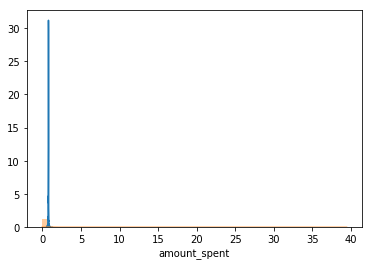

In [123]:
sns.distplot(oof_spent1)
sns.distplot(train_label['amount_spent'])

In [105]:
for trn_idx, val_idx in kf.split(train_activity_u2v):
    params = {
        'objective':'multiclass',
        'num_class':64,
        "boosting": "gbdt",
        'learning_rate': 0.03,
        'subsample' : 0.6,
        'sumsample_freq':1,
        'colsample_bytree':0.221856,
        'max_depth': 8,
        'max_bin':255,
        "lambda_l1": 0.25,
        "lambda_l2": 1,
        'min_child_weight': 0.2,
        'min_child_samples': 20,
        'min_gain_to_split':0.02,
        'min_data_in_bin':3,
        'bin_construct_sample_cnt':5000,
        'cat_l2':10,
        'verbose':-1,
        'nthread':-1,
        'seed':seed
    }
    
    trn_label = train_label.loc[trn_idx,'survival_time'] - 1    
    val_label = train_label.loc[val_idx, 'survival_time'] - 1

    train_df = lgb.Dataset(train_activity_u2v.drop(columns='acc_id').loc[trn_idx], label=trn_label)
    valid_df = lgb.Dataset(train_activity_u2v.drop(columns='acc_id').loc[val_idx], label=val_label)

    lgb_model = lgb.train(params, train_df, 5000, valid_sets = [train_df, valid_df], early_stopping_rounds = 500, verbose_eval=5000)
    oof_time1[val_idx] = np.argmax(lgb_model.predict(train_activity_u2v.drop(columns='acc_id').loc[val_idx]),axis=1)+1/skf.n_splits
    pred_time1 += np.argmax(lgb_model.predict(test1_activity_u2v),axis=1)+1/skf.n_splits
    pred_time2 += np.argmax(lgb_model.predict(test2_activity_u2v),axis=1)+1/skf.n_splits

Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[2]	training's multi_logloss: 2.423	valid_1's multi_logloss: 2.42569
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[3]	training's multi_logloss: 2.41708	valid_1's multi_logloss: 2.43327
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1]	training's multi_logloss: 2.42991	valid_1's multi_logloss: 2.41307
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[2]	training's multi_logloss: 2.42044	valid_1's multi_logloss: 2.43519
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1]	training's multi_logloss: 2.4211	valid_1's multi_logloss: 2.44847


/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


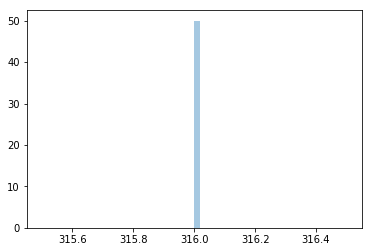

In [108]:
sns.distplot(pred_time1)

In [1]:
pred_time1

NameError: ignored